In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
import joblib
import matplotlib.pyplot as plt
from gdown import download

In [ ]:
# Download the base de dados
url = 'https://drive.google.com/uc?id=15FqnWO2ZSrWIjrZjMszGKd4MO43EyT1W'
output = 'base.csv'

download(url, output, quiet=False)

# Load data and define columns
df = pd.read_csv('base.csv', sep=';', encoding='utf-8')


# Remover as colunas "Status" e "Tipo"
df.drop(columns=['Status', 'Tipo', 'Matrícula'], inplace=True)

# Salvar a base de dados processada em um novo arquivo CSV
df.to_csv('processed_base.csv', index=False)

df.head()

Downloading...
From: https://drive.google.com/uc?id=15FqnWO2ZSrWIjrZjMszGKd4MO43EyT1W
To: /content/base.csv
100%|██████████| 719k/719k [00:00<00:00, 9.39MB/s]


,N° ocorrência,Data,Classificação,Localidade,UF,Aeródromo,Operação
0,84647,09/05/2024,INCIDENTE,GUARULHOS,SP,SBGR,NÃO REGULAR
1,84650,08/05/2024,INCIDENTE,MANAUS,AM,SBEG,NÃO REGULAR
2,84642,08/05/2024,INCIDENTE,SALVADOR,BA,***,REGULAR
3,84639,08/05/2024,INCIDENTE,GUARULHOS,SP,SBGR,REGULAR
4,84648,07/05/2024,ACIDENTE,IRACEMA,RR,***,PRIVADA


In [ ]:
#Valores nulos em cada coluna
valores_nulos = df.isnull().sum()

# Mostrar o resultado
print(valores_nulos)

N° ocorrência    0
Data             0
Classificação    0
Localidade       0
UF               0
Aeródromo        0
Operação         1
dtype: int64


In [ ]:
# Encontrar linhas com dados iguais em todas as colunas
linhas_duplicadas = df[df.duplicated(keep=False)]
linhas_duplicadas

,N° ocorrência,Data,Classificação,Localidade,UF,Aeródromo,Operação


In [ ]:
# Codificação das variáveis categóricas    Retirar Status e Tipos
categorical_features = ['Localidade', 'UF', 'Aeródromo', 'Operação']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])


In [ ]:
# Codificação da variável alvo
label_encoder = LabelEncoder()
df['Classificação'] = label_encoder.fit_transform(df['Classificação'])

In [ ]:
# Dividindo os dados em conjunto de treino e teste
X = df.drop('Classificação', axis=1)
y = df['Classificação']

In [ ]:
# Undersampling
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

In [ ]:
# Separando novamente os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [ ]:
# Definir o pipeline para o Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])



In [ ]:
# Definir o pipeline para o XGBoost
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42))])

In [ ]:
# Definir o pipeline para o LightGBM
lgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LGBMClassifier(random_state=42))])


In [ ]:
# Treinando e avaliando o Random Forest
rf_pipeline.fit(X_resampled, y_resampled)
rf_pred = rf_pipeline.predict(X_test)

# Defina os nomes das classes
target_names = ['ACIDENTE', 'INCIDENTE', 'INCIDENTE GRAVE']

print("Random Forest Classifier")
print(classification_report(y_test, rf_pred, target_names=target_names))

Random Forest Classifier
                 precision    recall  f1-score   support

       ACIDENTE       0.94      0.90      0.92       146
      INCIDENTE       0.91      0.94      0.92       139
INCIDENTE GRAVE       0.85      0.87      0.86       141

       accuracy                           0.90       426
      macro avg       0.90      0.90      0.90       426
   weighted avg       0.90      0.90      0.90       426



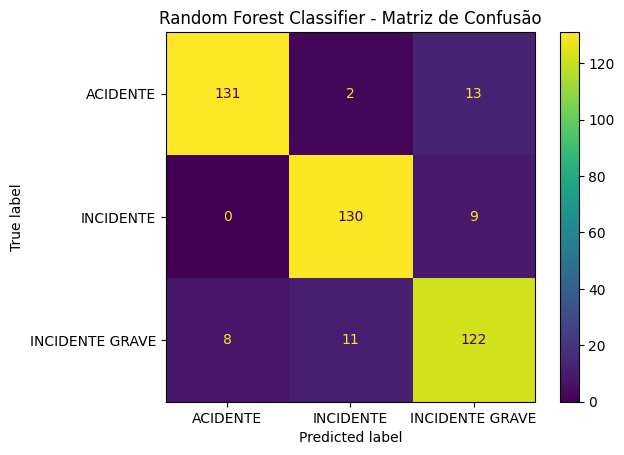

In [ ]:
# Gerar matriz de confusão para Random Forest
rf_cm = confusion_matrix(y_test, rf_pred, labels=rf_pipeline.named_steps['classifier'].classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=label_encoder.classes_)
disp_rf.plot()
plt.title('Random Forest Classifier - Matriz de Confusão')
plt.show()

In [ ]:
# Salvar o modelo Random Forest
joblib.dump(rf_pipeline, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [ ]:
# Treinando e avaliando o XGBoost
xgb_pipeline.fit(X_resampled, y_resampled)
xgb_pred = xgb_pipeline.predict(X_test)
print("XGBoost Classifier")
print(classification_report(y_test, xgb_pred, target_names=target_names))

XGBoost Classifier
                 precision    recall  f1-score   support

       ACIDENTE       0.73      0.80      0.76       146
      INCIDENTE       0.89      0.83      0.86       139
INCIDENTE GRAVE       0.67      0.65      0.66       141

       accuracy                           0.76       426
      macro avg       0.76      0.76      0.76       426
   weighted avg       0.76      0.76      0.76       426



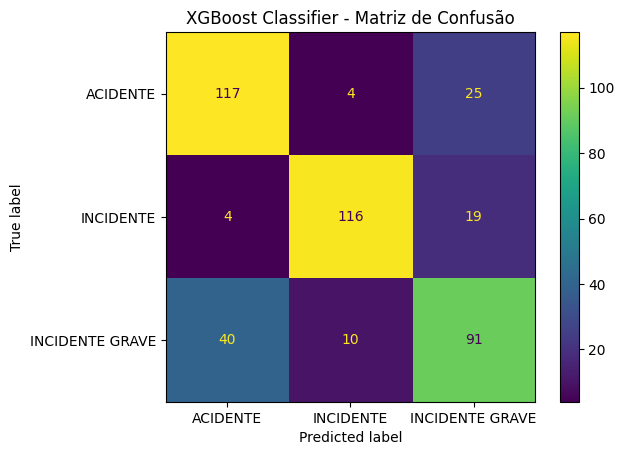

In [ ]:
# Gerar matriz de confusão para XGBoost
xgb_cm = confusion_matrix(y_test, xgb_pred, labels=xgb_pipeline.named_steps['classifier'].classes_)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=label_encoder.classes_)
disp_xgb.plot()
plt.title('XGBoost Classifier - Matriz de Confusão')
plt.show()

In [ ]:
# Salvar o modelo XGBoost
joblib.dump(xgb_pipeline, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [ ]:
# Treinando e avaliando o LightGBM
lgb_pipeline.fit(X_resampled, y_resampled)
lgb_pred = lgb_pipeline.predict(X_test)
print("LightGBM Classifier")
print(classification_report(y_test, lgb_pred, target_names=target_names))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 2130, number of used features: 64
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM Classifier
                 precision    recall  f1-score   support

       ACIDENTE       0.68      0.73      0.70       146
      INCIDENTE       0.87      0.81      0.84       139
INCIDENTE GRAVE       0.61      0.62      0.61       141

       accuracy                           0.72       426
      macro avg       0.72      0.72      0.72       426
   weighted avg       0.72      0.72      0.72       426



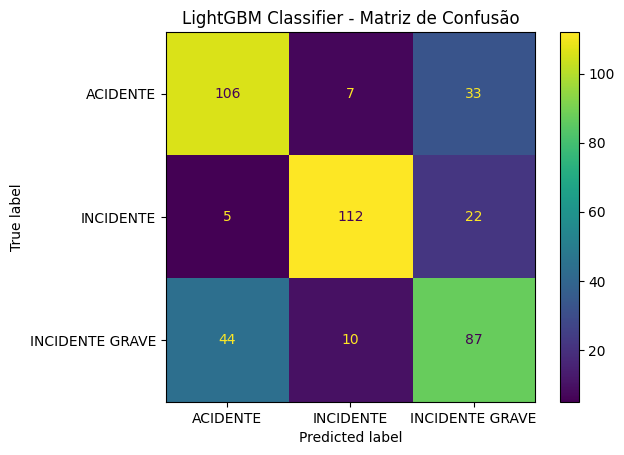

In [ ]:
# Gerar matriz de confusão para LightGBM
lgb_cm = confusion_matrix(y_test, lgb_pred, labels=lgb_pipeline.named_steps['classifier'].classes_)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=lgb_cm, display_labels=label_encoder.classes_)
disp_lgb.plot()
plt.title('LightGBM Classifier - Matriz de Confusão')
plt.show()

In [ ]:
# Salvar o modelo LightGBM
joblib.dump(lgb_pipeline, 'lightgbm_model.pkl')

['lightgbm_model.pkl']

In [ ]:
# Avaliação
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred) * 100:.2f}%")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_pred) * 100:.2f}%")
print(f"LightGBM Accuracy: {accuracy_score(y_test, lgb_pred) * 100:.2f}%")

Random Forest Accuracy: 89.91%
XGBoost Accuracy: 76.06%
LightGBM Accuracy: 71.60%
